# Uncover the factors to help measure how young children learn

### Setting Up

In [2]:
# File system management
import os
import gc

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Json for converting string to dict
import json

# Random for random
import random

# Datetime for handling date time variables
import datetime as dt

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from lightgbm import LGBMRegressor

# Sklearn importing folding methods method
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# Hyper paramater optimisation
import hyperopt as hopt

In [3]:
# Setting env vars
debug = True
random_seed = 42
random.seed(random_seed)

## Functions

In [4]:
# Using Ben Hamners quadratic weighted Kappa https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


In [5]:
# One-hot encoder for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Importing Data

Can be commented out after the first run

In [6]:
y_train = pd.read_csv("../data/train_labels.csv")
# Saving full training set as feather
y_train.reset_index().drop(columns = ['index']).to_feather("../data/y_train.feather")
print(y_train.shape)
# Creating sample for debuging
sample = y_train['installation_id'].sample(100, random_state=random_seed)
y_train_sample = y_train.where(y_train['installation_id'].isin(sample)).dropna()
y_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/y_train_sample.feather")
print(y_train_sample.shape)

(17690, 7)
(1276, 7)


In [7]:
X_train = pd.read_csv("../data/train.csv")
# Droping ids that never had an assessment
assessed = y_train['installation_id']
X_train = X_train.where(X_train['installation_id'].isin(assessed)).dropna()
# Saving full training set as feather
X_train.reset_index().drop(columns = ['index']).to_feather("../data/X_train.feather")
print(X_train.shape)
# Creating sample for debuging
X_train_sample = X_train.where(X_train['installation_id'].isin(sample)).dropna()
X_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_train_sample.feather")
print(X_train_sample.shape)

(7734558, 11)
(492271, 11)


In [5]:
X_test = pd.read_csv("../data/test.csv")
# Saving full training set as feather
X_test.reset_index().to_feather("../data/X_test.feather")
print(X_test.shape)
# Creating test sample for debuging
test_sample = X_test['installation_id'].sample(50, random_state=random_seed)
X_test_sample = X_test.where(X_test['installation_id'].isin(test_sample)).dropna()
X_test_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_test_sample.feather")
print(X_test_sample.shape)

(1156414, 11)
(165259, 11)


In [ ]:
# # Loading training set from feather
if debug:
    X_train = pd.read_feather("../data/X_train_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train.feather")
X_train.head()

In [278]:
# Meta data overview
X_train.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,492271,492271,492271,492271,492271,492271.000000,492271.000000,4.922710e+05,492271,492271,492271
unique,365,10879,466069,477977,97,NaN,NaN,NaN,44,4,4
top,bb3e370b,18596d22e575632f,2019-09-21T20:00:46.078Z,"{""event_code"": 2000, ""event_count"": 1}",4d7d3d97,NaN,NaN,NaN,Bottle Filler (Activity),Game,MAGMAPEAK
freq,10975,1125,7,5552,32749,NaN,NaN,NaN,42890,237952,213175
mean,NaN,NaN,NaN,NaN,NaN,102.368338,3508.390807,1.730410e+05,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,120.827067,678.246526,6.975832e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,26.000000,3020.000000,3.001900e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,61.000000,4020.000000,7.298000e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,131.000000,4035.000000,1.590370e+05,NaN,NaN,NaN


In [397]:
# Loading training target set from feather
if debug:
    y_train = pd.read_feather("../data/y_train_sample.feather")
else:
    y_train = pd.read_feather("../data/y_train.feather")
y_train.head()

,index,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [280]:
# Meta data overview
y_train.describe(include='all') # game_session is unique on the assessments

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
count,1276,1276,1276,1276.000000,1276.000000,1276.00000,1276.000000
unique,1276,97,5,NaN,NaN,NaN,NaN
top,40dbb48704146431,08987c08,Cauldron Filler (Assessment),NaN,NaN,NaN,NaN
freq,1,156,316,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.703762,1.958464,0.52534,1.681818
std,NaN,NaN,NaN,0.456776,3.288578,0.43997,1.292761
min,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
50%,NaN,NaN,NaN,1.000000,1.000000,0.50000,2.000000
75%,NaN,NaN,NaN,1.000000,3.000000,1.00000,3.000000


In [9]:
# Loading testing set from feather
if debug:
    X_test = pd.read_feather("../data/X_test_sample.feather")
else:
    X_test = pd.read_feather("../data/X_test.feather")
X_test.head()

,index,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [282]:
# Meta data overview
X_test.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,165259,165259,165259,165259,165259,165259.000000,165259.000000,1.652590e+05,165259,165259,165259
unique,357,3817,159754,161091,47,NaN,NaN,NaN,44,4,4
top,1325467d,b246933e8ac6a4aa,2019-09-13T18:38:38.848Z,"{""event_code"": 2000, ""event_count"": 1}",7b728c89,NaN,NaN,NaN,Bottle Filler (Activity),Game,MAGMAPEAK
freq,6781,4456,9,2314,21237,NaN,NaN,NaN,24512,76021,85994
mean,NaN,NaN,NaN,NaN,NaN,206.108224,3537.043834,1.670670e+05,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,485.163273,670.874650,4.183720e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,31.000000,3021.000000,3.387250e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,77.000000,4020.000000,8.114000e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,179.000000,4070.000000,1.790050e+05,NaN,NaN,NaN


In [10]:
gc.collect()

43

### Exploring the data

In [234]:
X_train.type.unique()

array(['Clip', 'Game', 'Assessment', 'Activity'], dtype=object)

##### Looking at game_sessions; these are unique in the training target data-set

In [72]:
X_train.where(X_train.game_session == '13fb574a0788a342').dropna().head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1323,7ad3efc6,13fb574a0788a342,2019-08-11T12:05:34.005Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00e17272,1.0,2000.0,0.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1324,65a38bf7,13fb574a0788a342,2019-08-11T12:05:34.081Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00e17272,2.0,2020.0,57.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1325,795e4a37,13fb574a0788a342,2019-08-11T12:05:34.086Z,"{""description"":""We've got to balance this scal...",00e17272,3.0,3010.0,57.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1326,acf5c23f,13fb574a0788a342,2019-08-11T12:05:37.276Z,"{""coordinates"":{""x"":463,""y"":559,""stage_width"":...",00e17272,4.0,4070.0,3270.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1327,5e109ec3,13fb574a0788a342,2019-08-11T12:05:38.019Z,"{""crystal_id"":""gem03"",""weight"":3,""coordinates""...",00e17272,5.0,4030.0,4020.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [15]:
y_train.where(y_train.game_session == '13fb574a0788a342').dropna()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,13fb574a0788a342,00e17272,Cart Balancer (Assessment),1.0,0.0,1.0,3.0


In [90]:
X_train.where(X_train.title == 'Bird Measurer (Assessment)').dropna().head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
663,f56e0afc,6c8fab7964639f37,2019-08-10T18:12:28.453Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00e17272,1.0,2000.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
664,ec138c1c,6c8fab7964639f37,2019-08-10T18:12:28.503Z,"{""stage_number"":1,""event_count"":2,""game_time"":...",00e17272,2.0,2020.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
665,1375ccb7,6c8fab7964639f37,2019-08-10T18:12:28.506Z,"{""description"":""Use the caterpillars to measur...",00e17272,3.0,3010.0,0.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
666,bdf49a58,6c8fab7964639f37,2019-08-10T18:12:33.096Z,"{""description"":""Use the caterpillars to measur...",00e17272,4.0,3110.0,4695.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
667,51102b85,6c8fab7964639f37,2019-08-10T18:12:33.328Z,"{""hat"":0,""caterpillar"":""left"",""coordinates"":{""...",00e17272,5.0,4030.0,4911.0,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [154]:
# Chcking the number of assessments
X_train_assessed = X_train.where(((X_train.type == 'Assessment') & (X_train.event_code == 4100)) | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110))).dropna()
X_train_assessed.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,3523,3523,3523,3523,3523,3523.000000,3523.000000,3.523000e+03,3523,3523,3523
unique,6,1276,3523,3522,97,NaN,NaN,NaN,5,1,3
top,392e14df,7136d0fb1283ae19,2019-09-11T14:47:26.592Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,TREETOPCITY
freq,934,36,1,2,593,NaN,NaN,NaN,934,3523,1474
mean,NaN,NaN,NaN,NaN,NaN,44.873403,4102.128867,7.397595e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,42.781803,4.094063,4.448047e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,1.748000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,4100.000000,1.752050e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,33.000000,4100.000000,2.996700e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,54.000000,4100.000000,5.454150e+04,NaN,NaN,NaN


In [155]:
# Getting the final entry for each game_session
idx = X_train_assessed.groupby(['game_session'])['event_count'].transform(max) == X_train_assessed['event_count']
X_train_assessed_last_session_event = X_train_assessed[idx]
X_train_assessed_last_session_event.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,1276,1276,1276,1276,1276,1276.000000,1276.000000,1.276000e+03,1276,1276,1276
unique,6,1276,1276,1275,97,NaN,NaN,NaN,5,1,3
top,392e14df,40dbb48704146431,2019-09-10T18:22:45.667Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,316,1,1,2,156,NaN,NaN,NaN,316,1276,496
mean,NaN,NaN,NaN,NaN,NaN,40.387147,4100.705329,6.601858e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,36.511709,2.561434,3.509608e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,2.031000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,18.000000,4100.000000,1.686725e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,32.000000,4100.000000,2.801600e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,49.000000,4100.000000,5.043200e+04,NaN,NaN,NaN


In [109]:
X_train_assessed_last_session_event.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
377,392e14df,9444d34477d7f2c5,2019-08-10T18:02:42.206Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,40.0,4100.0,38307.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
404,392e14df,a8c4aa084792d9bc,2019-08-10T18:03:24.464Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,13.0,4100.0,8389.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
503,25fa8af4,b1fa320f360a5df7,2019-08-10T18:07:26.756Z,"{""correct"":true,""stumps"":[2,3,5],""event_count""...",00e17272,32.0,4100.0,26065.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
709,070a5291,6c8fab7964639f37,2019-08-10T18:13:22.509Z,"{""correct"":true,""hats"":[4,8,5],""event_count"":4...",00e17272,47.0,4100.0,54099.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
827,392e14df,a8f34c37b52dcf4e,2019-08-10T18:18:27.391Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",00e17272,13.0,4100.0,7787.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [112]:
X_train_session_not_assessed = X_train.where((X_train.type == 'Assessment') & ~X_train.game_session.isin(y_train.game_session)).dropna()
X_train_session_not_assessed.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1471,7ad3efc6,9837bf9935e06e0b,2019-08-11T12:19:21.079Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00e17272,1.0,2000.0,0.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1472,65a38bf7,9837bf9935e06e0b,2019-08-11T12:19:21.151Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00e17272,2.0,2020.0,47.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
1473,795e4a37,9837bf9935e06e0b,2019-08-11T12:19:21.157Z,"{""description"":""We've got to balance this scal...",00e17272,3.0,3010.0,47.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
6561,3bfd1a65,ad52e0640c0b3415,2019-08-05T23:02:57.138Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",08987c08,1.0,2000.0,0.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
6562,db02c830,ad52e0640c0b3415,2019-08-05T23:02:57.206Z,"{""event_count"":2,""game_time"":46,""event_code"":2...",08987c08,2.0,2025.0,46.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [115]:
# There are some assessment game_sessions where there was no final assessment (possibly?) because the assesment was not finished so didn't end up in the target set. It could be very powerful to know if there have been prior uncompleated attemts at the 
# assessments. If there have been prior compleated attempts this could be even more powerfull. Also there are some game_sessions with events after the asessment event could be useful.
print(X_train_session_not_assessed.event_code.unique())
print(X_train_session_not_assessed.event_id.unique())
# X_train_not_completed.head()
print("Code 4035", X_train_session_not_assessed.event_data[444147])
print("Code 2020", X_train_session_not_assessed.event_data[11597])
print("id 'c74f40cd'", X_train_session_not_assessed.event_data[265229])
X_train_session_not_assessed.describe(include='all')

[2000. 2020. 3010. 2025. 3110. 4070. 4025. 3021. 3121. 2035. 4090. 4030.
 4040. 4035. 4020.]
['7ad3efc6' '65a38bf7' '795e4a37' '3bfd1a65' 'db02c830' 'a1e4395d'
 'a52b92d5' '7da34a02' '28ed704e' '9d29771f' 'c74f40cd' '3dfd4aa4'
 '83c6c409' 'eb2c19cd' 'fbaf3456' 'c7128948' 'f56e0afc' 'ec138c1c'
 '1375ccb7' '90d848e0' '923afab1' '532a2afb' '2dcad279' '5b49460a'
 '155f62a4' '3dcdda7f' '3ccd3f02' 'bd612267' 'acf5c23f' '828e68f9'
 '5e109ec3' '3d63345e' '5c2f29ca' '9d4e7b25' 'bdf49a58' 'a8efe47b'
 '562cec5f' '0db6d71d' '51102b85' '4a4c3d21' 'a16a373e' '5f0eb72c'
 '37ee8496' '30614231' '9ce586dd' '4e5fc6f5' '3d0b9317' '3ee399c3'
 '5348fd84' '77c76bc5' '3edf6747']
Code 4035 {"bucket":2,"source":"resources","coordinates":{"x":498,"y":385,"stage_width":1015,"stage_height":762},"duration":938,"event_count":6,"game_time":6992,"event_code":4035}
Code 2020 {"buckets":[1,3,2],"target_bucket":0,"mode":"placing","prompt":"N/A","round_number":1,"event_count":3,"game_time":396,"event_code":2020}
id 'c74f4

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,3234,3234,3234,3234,3234,3234.000000,3234.000000,3234.000000,3234,3234,3234
unique,51,260,3175,2748,55,NaN,NaN,NaN,5,1,3
top,7da34a02,499403656d2f3958,2019-09-13T23:41:32.552Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",8e44d2de,NaN,NaN,NaN,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
freq,371,200,3,260,834,NaN,NaN,NaN,1551,3234,1783
mean,NaN,NaN,NaN,NaN,NaN,19.541744,3360.638837,19418.220470,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,28.977325,770.612915,41656.196675,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,2000.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.000000,3010.000000,1946.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,10.000000,3121.000000,7999.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,23.000000,4035.000000,21390.500000,NaN,NaN,NaN


In [128]:
# Chcking the entries after the assessments
X_train_assessment = X_train.where(X_train.game_session.isin(X_train_assessed.game_session)).dropna()
idx = X_train_assessment.groupby(['game_session'])['event_count'].transform(max) == X_train_assessment['event_count']
X_train_assessment_last_session_event = X_train_assessment[idx]
X_train_after_assessed = X_train_assessment_last_session_event.where(~(X_train_assessment_last_session_event.event_code == 4100) & ~((X_train_assessment_last_session_event.title == 'Bird Measurer (Assessment)') 
                                                                                                                                     & (X_train_assessment_last_session_event.event_code == 4110))).dropna()
print(X_train_after_assessed.event_code.unique())
X_train_after_assessed.describe(include='all')

[2010. 3120. 3121. 4070. 4020. 3020. 3010. 4080. 3110. 4025. 4040. 4035.
 3021. 2020. 2030. 4030.]


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,1274,1274,1274,1274,1274,1274.000000,1274.000000,1.274000e+03,1274,1274,1274
unique,54,1274,1274,1274,97,NaN,NaN,NaN,5,1,3
top,b2e5b0f1,40dbb48704146431,2019-09-05T01:16:56.832Z,"{""session_duration"":44050,""event_count"":57,""ga...",08987c08,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,229,1,1,1,156,NaN,NaN,NaN,316,1274,495
mean,NaN,NaN,NaN,NaN,NaN,49.255887,2537.321821,8.057352e+04,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,39.146116,736.935700,3.829955e+05,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,6.000000,2010.000000,2.031000e+03,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,29.000000,2010.000000,2.700950e+04,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,39.000000,2010.000000,3.768950e+04,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,58.000000,3110.000000,6.056150e+04,NaN,NaN,NaN


In [132]:
print("Code 4035", X_train_after_assessed.event_data[28046])
print("Code 2020", X_train_after_assessed.event_data[40898])
print("id 'c74f40cd'", X_train_after_assessed.event_data[263296])
X_train_after_assessed.head()

Code 4035 {"bucket":3,"source":"resources","coordinates":{"x":205,"y":400,"stage_width":1015,"stage_height":762},"duration":351,"event_count":34,"game_time":31051,"event_code":4035}
Code 2020 {"buckets":[],"target_bucket":1,"mode":"selecting","prompt":"holds least","round_number":2,"event_count":28,"game_time":25666,"event_code":2020}
id 'c74f40cd' {"description":"two...","identifier":"Dot_Two","media_type":"audio","duration":551,"event_count":28,"game_time":24323,"event_code":3121}


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
390,2b058fe3,9444d34477d7f2c5,2019-08-10T18:02:57.713Z,"{""session_duration"":53823,""event_count"":53,""ga...",00e17272,53.0,2010.0,53823.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
417,2b058fe3,a8c4aa084792d9bc,2019-08-10T18:03:39.183Z,"{""session_duration"":23120,""event_count"":27,""ga...",00e17272,27.0,2010.0,23120.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
508,a5be6304,b1fa320f360a5df7,2019-08-10T18:07:35.533Z,"{""session_duration"":34849,""exit_type"":""game_co...",00e17272,37.0,2010.0,34849.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
711,3393b68b,6c8fab7964639f37,2019-08-10T18:13:24.651Z,"{""session_duration"":56248,""event_count"":49,""ga...",00e17272,49.0,2010.0,56248.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
870,2b058fe3,a8f34c37b52dcf4e,2019-08-10T18:18:39.668Z,"{""session_duration"":20071,""event_count"":57,""ga...",00e17272,57.0,2010.0,20071.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


##### There does seem to be ways to identify the completed assessments. For event_code 2020 uncompleated seems to have 0 as the target bucket and mode = "placing" when uncomplete. Also, event_code 4035 showed that the event_codes are not always unique to the title or even the world. Could possibly break down each event_code and find out what it can tell us about the solution.

In [76]:
X_train_last_session_event.where(X_train_last_session_event.installation_id == '4b02b17f').dropna().head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
121669,b2e5b0f1,d5a43735f1be480f,2019-09-16T14:39:47.194Z,"{""session_duration"":24464,""event_count"":13,""ga...",4b02b17f,13.0,2010.0,24464.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121697,b2e5b0f1,eb378b198af17c8a,2019-09-16T14:40:58.469Z,"{""session_duration"":47406,""event_count"":27,""ga...",4b02b17f,27.0,2010.0,47406.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121726,b2e5b0f1,2983d3d98ca61e5d,2019-09-16T14:41:47.440Z,"{""session_duration"":38603,""event_count"":30,""ga...",4b02b17f,30.0,2010.0,38603.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121754,b2e5b0f1,bb1e267cb5c16cd0,2019-09-16T14:42:29.045Z,"{""session_duration"":35788,""event_count"":27,""ga...",4b02b17f,27.0,2010.0,35788.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
121903,828e68f9,112e35b88f7cbeab,2019-09-16T14:49:48.927Z,"{""description"":""We've got to balance this scal...",4b02b17f,5.0,3110.0,7214.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [135]:
# There seems to be alot of target assessments for the same title and installation ID (repeating the task?). This is odd because the sample submission is by installation_id
y_train.where(y_train.installation_id == '4b02b17f').dropna().head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
369,0060b5da47c841d3,4b02b17f,Bird Measurer (Assessment),1.0,0.0,1.0,3.0
370,0135bc6c31257054,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0
371,1ea8453ff8b63657,4b02b17f,Bird Measurer (Assessment),1.0,0.0,1.0,3.0
372,253458d154d359ee,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0
373,264d23821d528008,4b02b17f,Cauldron Filler (Assessment),1.0,0.0,1.0,3.0


#### Checking the test set for duplicate attempts at the same assessment

In [136]:
# Chcking the number of assessments
X_test_assessed = X_test.where(((X_test.type == 'Assessment') & (X_test.event_code == 4100)) | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110))).dropna()
X_test_assessed.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,635,635,635,635,635,635.000000,635.000000,635.000000,635,635,635
unique,6,202,635,635,41,NaN,NaN,NaN,5,1,3
top,17113b36,0db4f6f4be3730a2,2019-08-12T20:16:33.313Z,"{""correct"":true,""stumps"":[2,4,5],""event_count""...",7b728c89,NaN,NaN,NaN,Bird Measurer (Assessment),Assessment,TREETOPCITY
freq,200,63,1,1,87,NaN,NaN,NaN,239,635,306
mean,NaN,NaN,NaN,NaN,NaN,63.308661,4103.149606,58425.626772,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,75.829560,4.648664,67055.821495,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,1711.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,24.000000,4100.000000,20528.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,38.000000,4100.000000,34838.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,68.000000,4110.000000,68299.500000,NaN,NaN,NaN


In [137]:
# Getting the final entry for each game_session
idx = X_test_assessed.groupby(['game_session'])['event_count'].transform(max) == X_test_assessed['event_count']
X_test_assessed_last_session_event = X_test_assessed[idx]
X_test_assessed_last_session_event.describe(include = 'all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
count,202,202,202,202,202,202.000000,202.000000,202.000000,202,202,202
unique,6,202,202,202,41,NaN,NaN,NaN,5,1,3
top,392e14df,86a6f6c61a2f62ef,2019-09-06T19:27:17.753Z,"{""correct"":true,""stumps"":[2,4,5],""event_count""...",7b728c89,NaN,NaN,NaN,Cauldron Filler (Assessment),Assessment,CRYSTALCAVES
freq,50,1,1,1,24,NaN,NaN,NaN,50,202,77
mean,NaN,NaN,NaN,NaN,NaN,47.267327,4100.346535,46411.811881,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,51.082684,1.833549,53390.696995,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,4.000000,4100.000000,2757.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,22.000000,4100.000000,19532.250000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,34.000000,4100.000000,29541.500000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,57.000000,4100.000000,50507.750000,NaN,NaN,NaN


In [65]:
print(X_test_last_session_event.event_code.unique())
# X_train_not_completed.head()
# print("Code 4035", X_test_last_session_event.event_data[444147])
# print("Code 2020", X_test_last_session_event.event_data[11597])
X_test_last_session_event.where(X_test_last_session_event.event_code==2020).dropna().head(10) #

[2010. 4070. 2000. 2020. 3120. 3110. 3010. 4040. 4025. 3021. 3020. 2030.
 4020.]


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
5793,532a2afb,9f3704b259908824,2019-08-09T17:01:09.101Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",0b24b6ac,33.0,2020.0,22630.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
14915,532a2afb,ef8ac8d2a802f341,2019-08-13T15:34:20.848Z,"{""buckets"":[2,1,3],""target_bucket"":0,""mode"":""p...",1121f331,3.0,2020.0,384.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
21982,532a2afb,0f4fab1560bc9aff,2019-08-29T19:27:25.802Z,"{""buckets"":[1,3,2],""target_bucket"":0,""mode"":""p...",1121f331,3.0,2020.0,395.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
26215,532a2afb,1aa3e32d4423dcc0,2019-09-16T20:52:00.828Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",1baa3c99,3.0,2020.0,390.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
31268,532a2afb,ebf8cd7badd2af8b,2019-08-12T20:04:06.529Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",2e6923d6,32.0,2020.0,24222.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
50028,532a2afb,6f43d1a59737af7c,2019-08-17T01:27:57.789Z,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",4da8008a,22.0,2020.0,17510.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
96211,532a2afb,1a52f4714336fdec,2019-08-27T19:13:28.346Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",87b899d9,3.0,2020.0,385.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
119045,532a2afb,2420e72bab61e0ec,2019-09-16T11:47:51.994Z,"{""buckets"":[1,3,2],""target_bucket"":0,""mode"":""p...",9a13c8a2,3.0,2020.0,393.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
119813,532a2afb,b8208bcd3024f5d6,2019-09-21T18:17:43.618Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",9a13c8a2,3.0,2020.0,399.0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [71]:
y_test_sample_submission = pd.read_csv("../data/sample_submission.csv")
y_test_sample_submission.installation_id.unique().size

1000

In [138]:
# Why are the sample submission installation_id's distinct but the target sets ids are not...
y_test_sample_submission.describe(include='all')

,installation_id,accuracy_group
count,1000,1000.0
unique,1000,NaN
top,9b001268,NaN
freq,1,NaN
mean,NaN,3.0
std,NaN,0.0
min,NaN,3.0
25%,NaN,3.0
50%,NaN,3.0
75%,NaN,3.0


## Feature Engineering

##### Creating temporal features

In [11]:
X_train['weekday'] = pd.to_datetime(X_train['timestamp']).dt.weekday
X_test['weekday'] = pd.to_datetime(X_test['timestamp']).dt.weekday

In [12]:
X_train['time']  = pd.to_datetime(X_train['timestamp']).dt.hour
X_test['time']  = pd.to_datetime(X_test['timestamp']).dt.hour

### Basic Data Prep

In [47]:
# Getting a single entry for each target output
X_train_ = X_train.where(((X_train.type == 'Assessment') & (X_train.event_code == 4100)) | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110))).dropna()
idx = X_train_.groupby(['game_session'])['event_count'].transform(max) == X_train_['event_count']
X_train_ = X_train_[idx]
X_train_ = X_train_.where(X_train_.game_session.isin(y_train.game_session)).dropna()

In [48]:
# Getting a single entry for each target output
X_test_ = X_test.where(((X_test.type == 'Assessment') & (X_test.event_code == 4100)) | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110))).dropna()
idx = X_test_.groupby(['game_session'])['event_count'].transform(max) == X_test_['event_count']
X_test_ = X_test_[idx]

In [49]:
# Droping variables
X_train_.drop(columns=['timestamp', 'installation_id', 'game_session', 'event_data'], inplace=True)
X_test_.drop(columns=['timestamp', 'installation_id', 'game_session', 'event_data'], inplace=True)

In [50]:
# Concatenating the tables to one_hot_encode with the same categories then spliting again
df = pd.concat([X_train_, X_test_],ignore_index=True)
df, _ = one_hot_encoder(df, nan_as_category=True)
X_train_ = df.iloc[:len(X_train_.index)]
X_test_ = df.iloc[len(X_train_.index):].reset_index().drop(columns=['index'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [51]:
print("train shape:", (len(X_train_.index), len(X_train_.columns)))
print("test shape:", (len(X_test_.index), len(X_test_.columns)))

train shape: (17690, 25)
test shape: (2018, 25)


## Creating a baseline fit with basic data to prep the model

In [64]:
# Initializing lgbm paramaters
params={'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.03,
        'n_estimators': 1000,
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state": random_seed,
        'min_child_samples': 20
       }

In [65]:
# unique_vis = np.array(sorted(pd.Series(X_train.index.values).unique()))
# Get folds
nfolds = 11
Kfolds = KFold(n_splits=nfolds, shuffle=True, random_state=random_seed)
folds = []
for train, valid in Kfolds.split(X=X_train_):
    folds.append([train, valid])

In [66]:
# Setting temp target
y_train_ = y_train

In [67]:
y_train_.accuracy_group.describe(include='all')

count    17690.000000
mean         1.885585
std          1.256796
min          0.000000
25%          1.000000
50%          2.500000
75%          3.000000
max          3.000000
Name: accuracy_group, dtype: float64

In [68]:
# Initializing Variables
prd_train = pd.Series(np.zeros(y_train_.shape[0]))
prd_test = np.zeros(X_test_.shape[0])
imp = pd.DataFrame()
wgt_sum = 0
MSE = 0
avg_kappa = 0

for n_fld, (trn_idx, vld_idx) in enumerate(folds):
    #trn_idx = idx_tab.iloc[trn_num].index
    #vld_idx = idx_tab.iloc[vld_num].index
    X_train__, y_train__ = X_train_.iloc[trn_idx], y_train_.iloc[trn_idx]
    X_valid, y_valid = X_train_.iloc[vld_idx], y_train_.loc[vld_idx]
    
    lgb = LGBMRegressor(**params)
    
    # Fit the model
    lgb.fit(X_train__, y_train__.accuracy_group)
    
    # applying the model to the validation data
    prd_valid = lgb.predict(X_valid)
    # Calculating and outputting the RMSE
    y_valid = np.array(np.round_(y_valid.accuracy_group, decimals=0).astype(int))
    prd_valid = np.array(np.round_(prd_valid, decimals=0).astype(int))
    fld_MSE = (np.square(y_valid - prd_valid)).mean()
    print(f"Fold {n_fld + 1} RMSE: {fld_MSE}")
    fld_QWK = quadratic_weighted_kappa(y_valid, prd_valid)
    print(f"Fold {n_fld + 1} kappa: {fld_QWK}")
    # Summing mean squared errors
    MSE += fld_MSE/nfolds
    wgt_sum += 1/np.sqrt(fld_MSE)
    avg_kappa += fld_QWK/nfolds
    
    # Applying predictions to the train set weighted by the MSE
    prd = lgb.predict(X_valid)
    prd = np.array(np.round_(prd, decimals=0).astype(int))
    prd_train.iloc[vld_idx] = prd
    
    # Applying predictions to the test set weighted by the MSE
    prd = lgb.predict(X_test_)
    prd_test += prd/nfolds
    
    # Calculating the fold importance
    imp_df = pd.DataFrame()
    imp_df['fts'] = X_train__.columns
    imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')
    
    # Summing the fold importances
    imp_df['fld'] = n_fld+1
    imp = pd.concat([imp, imp_df], axis=0, sort=False)

print("RMSE:", np.sqrt(MSE))
print("Kappa:", quadratic_weighted_kappa(y_train_.accuracy_group, prd_train))

Fold 1 RMSE: 1.678060907395898
Fold 1 kappa: 0.08353012306935437
Fold 2 RMSE: 1.5152268489745184
Fold 2 kappa: 0.13047847886899344
Fold 3 RMSE: 1.6013681592039801
Fold 3 kappa: 0.07339608859735214
Fold 4 RMSE: 1.5870646766169154
Fold 4 kappa: 0.07990012484394504
Fold 5 RMSE: 1.6194029850746268
Fold 5 kappa: 0.10356955225491038
Fold 6 RMSE: 1.5895522388059702
Fold 6 kappa: 0.10299817720882498
Fold 7 RMSE: 1.625
Fold 7 kappa: 0.08722978838401785
Fold 8 RMSE: 1.6218905472636815
Fold 8 kappa: 0.0957132857994909
Fold 9 RMSE: 1.580223880597015
Fold 9 kappa: 0.10964735661278269
Fold 10 RMSE: 1.5727611940298507
Fold 10 kappa: 0.12228210899277125
Fold 11 RMSE: 1.572139303482587
Fold 11 kappa: 0.10450349472882825
RMSE: 1.2635696455764822
Kappa: 0.09949348716950535


Text(0.5, 1.0, 'Features (avg over folds)')

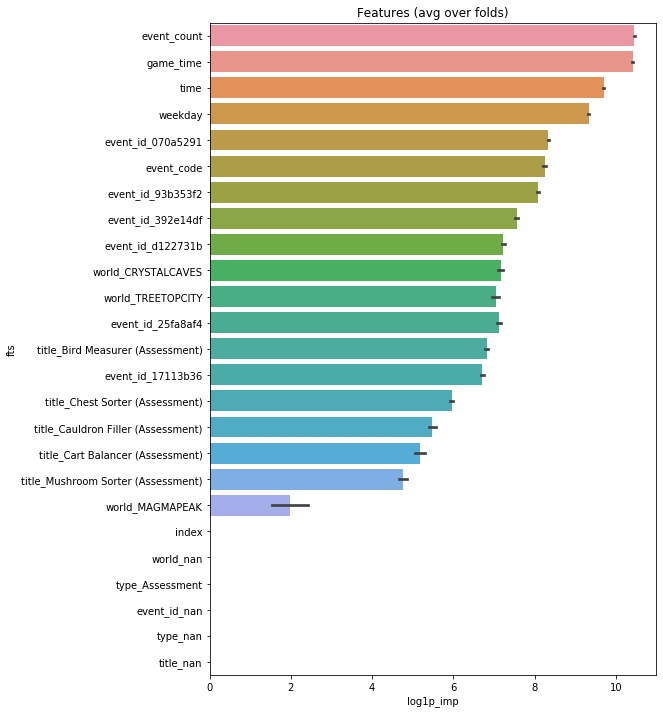

In [69]:
# Ploting stage 1 feature importances
cols = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60].index
imp['log1p_imp'] = np.log1p(imp['imp'])
best_features = imp.loc[imp.fts.isin(cols)]
plt.figure(figsize=(8, 12))
sns.barplot(x="log1p_imp", y="fts", data=best_features.sort_values(by="imp", ascending=False))
plt.title('Features (avg over folds)')

### Prepairing the Data

Putting the event_data breakdown on hold

In [13]:
# # Splitting out event_data into columns
# event_data_train = pd.DataFrame(X_train['event_data'].apply(json.loads).values.tolist())
# event_data_train.columns = [f"event_data.{col}" for col in event_data_train.columns]
# X_train = pd.concat([X_train, event_data_train],axis=1)
# X_train = X_train.drop(columns=['event_data', 'event_data.event_count', 'event_data.event_code'])
# X_train.head()

,event_id,game_session,timestamp,installation_id,event_count,event_code,game_time,title,type,world,...,event_data.molds,event_data.tape_length,event_data.bug_length,event_data.dwell_time,event_data.chests,event_data.target_size,event_data.object_type,event_data.group,event_data.max_position,event_data.end_position
0,27253bdc,a3325b38ad7292c1,2019-08-10T17:46:03.082Z,00e17272,1.0,2000.0,0.0,Welcome to Lost Lagoon!,Clip,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,4d23feebc743419e,2019-08-10T17:46:18.684Z,00e17272,1.0,2000.0,0.0,Magma Peak - Level 1,Clip,MAGMAPEAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27253bdc,4b0eef97c4521434,2019-08-10T17:47:13.391Z,00e17272,1.0,2000.0,0.0,Magma Peak - Level 2,Clip,MAGMAPEAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27253bdc,c3e85417476eeae5,2019-08-10T17:47:51.101Z,00e17272,1.0,2000.0,0.0,Welcome to Lost Lagoon!,Clip,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27253bdc,9da134e1cb08364c,2019-08-10T17:48:21.252Z,00e17272,1.0,2000.0,0.0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# X_train.columns.values

array(['event_id', 'game_session', 'timestamp', 'installation_id',
       'event_count', 'event_code', 'game_time', 'title', 'type', 'world',
       'event_data.version', 'event_data.round', 'event_data.game_time',
       'event_data.coordinates', 'event_data.description',
       'event_data.identifier', 'event_data.media_type',
       'event_data.total_duration', 'event_data.duration',
       'event_data.dinosaur', 'event_data.diet',
       'event_data.target_weight', 'event_data.resources',
       'event_data.weight', 'event_data.source', 'event_data.correct',
       'event_data.scale_weight', 'event_data.scale_contents',
       'event_data.misses', 'event_data.tutorial_step',
       'event_data.dinosaur_weight', 'event_data.mode',
       'event_data.dinosaur_count', 'event_data.shells',
       'event_data.holes', 'event_data.holding_shell',
       'event_data.has_water', 'event_data.shell_size',
       'event_data.position', 'event_data.hole_position',
       'event_data.target_wate

In [15]:
# X_train.describe()

,event_count,event_code,game_time,event_data.round,event_data.game_time,event_data.total_duration,event_data.duration,event_data.target_weight,event_data.weight,event_data.scale_weight,...,event_data.containers,event_data.current_containers,event_data.total_containers,event_data.tape_length,event_data.bug_length,event_data.dwell_time,event_data.target_size,event_data.group,event_data.max_position,event_data.end_position
count,492271.000000,492271.000000,4.922710e+05,280842.000000,4.867190e+05,85975.000000,1.648240e+05,6337.000000,25134.000000,3725.000000,...,504.000000,2316.000000,2316.000000,7.0,7.0,44.000000,972.000000,1358.000000,56.000000,56.000000
mean,102.368338,3508.390807,1.730410e+05,6.442676,1.750149e+05,3684.223833,4.140505e+04,3.257535,2.873200,4.132617,...,4.611111,3.415803,5.622193,0.0,0.0,7190.113636,3.354938,3.313697,0.397661,0.382890
std,120.827067,678.246526,6.975832e+05,9.155236,7.013043e+05,3390.344814,7.289470e+05,2.018683,1.924208,2.163217,...,2.429842,2.183640,2.578732,0.0,0.0,15391.278493,0.934820,0.942865,0.447578,0.431906
min,1.000000,2000.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.0,0.0,1000.000000,2.000000,2.000000,0.000000,0.000000
25%,26.000000,3020.000000,3.001900e+04,1.000000,3.118500e+04,1633.000000,8.590000e+02,2.000000,1.000000,3.000000,...,2.000000,2.000000,3.000000,0.0,0.0,1666.750000,3.000000,3.000000,0.000000,0.000000
50%,61.000000,4020.000000,7.298000e+04,3.000000,7.425100e+04,2813.000000,1.967000e+03,3.000000,3.000000,4.000000,...,4.000000,3.000000,5.000000,0.0,0.0,2666.500000,3.000000,3.000000,0.058383,0.074162
75%,131.000000,4035.000000,1.590370e+05,7.000000,1.605000e+05,4733.000000,4.184000e+03,4.000000,3.000000,6.000000,...,6.000000,5.000000,8.000000,0.0,0.0,4423.250000,4.000000,4.000000,1.000000,0.899408
max,1125.000000,5010.000000,6.668400e+07,97.000000,6.668400e+07,44733.000000,3.141394e+07,11.000000,12.000000,8.000000,...,9.000000,9.000000,9.000000,0.0,0.0,91907.000000,5.000000,5.000000,1.000000,1.000000


In [16]:
# # Splitting out event_data into columns
# event_data_test = pd.DataFrame(X_test['event_data'].apply(json.loads).values.tolist())
# event_data_test.columns = [f"event_data.{col}" for col in event_data_test.columns]
# X_test = pd.concat([X_test, event_data_test],axis=1)
# X_test = X_test.drop(columns=['event_data', 'event_data.event_count', 'event_data.event_code'])
# X_test.shape

(165259, 130)

In [23]:
# X_train['event_data.end_position'].dropna().size # Some event columns are very sparse

56

In [25]:
# y_train.describe(include='all')

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
count,1276,1276,1276,1276.000000,1276.000000,1276.00000,1276.000000
unique,1276,97,5,NaN,NaN,NaN,NaN
top,56564b8cc798a982,08987c08,Cauldron Filler (Assessment),NaN,NaN,NaN,NaN
freq,1,156,316,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.703762,1.958464,0.52534,1.681818
std,NaN,NaN,NaN,0.456776,3.288578,0.43997,1.292761
min,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000
50%,NaN,NaN,NaN,1.000000,1.000000,0.50000,2.000000
75%,NaN,NaN,NaN,1.000000,3.000000,1.00000,3.000000


In [ ]:
# Too many values dont have the ram
# X_train, _ = one_hot_encoder(X_train, nan_as_category=True)

In [ ]:
# X_train.shape

#### Fitting LightGBM

Running a quick fit to get a better idea of the assessments and kappa